# Setup

In [1]:
import os
FOLDERNAME = os.getcwd()
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append(FOLDERNAME)

# Change work directory to the current one
import os
os.chdir(FOLDERNAME)
print(f'Current folder changed to {os.getcwd()}')

Current folder changed to c:\Users\user\Desktop\zhuyi\PTI\camus-hands-on-main\camus_vae


In [2]:
import numpy as np
from tqdm import tqdm
import logging
from pathlib import Path
from tqdm.auto import tqdm
import random
import colorsys
from medpy.metric.binary import hd, assd

import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from monai.data import CacheDataset

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 4) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

c:\Users\user\Desktop\zhuyi\PTI\env_pytorch\pytorch1.12-cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from cs230 import utils, net, data, visu
from cs230.train import train_and_evaluate
from cs230.evaluate import predict, calculate_metrics_on_one_set, dice_coeff_single_img_single_label
from cs230.unet import UNet
from cs230.dice_loss import DC_and_CE_loss

# Configuration

In [4]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

class Params():
    def __init__(self,params_dict):
        self.__dict__.update(params_dict)

    def update(self,params_dict):
        self.__dict__.update(params_dict)

params_dict = {
               'IMG_SIZE' : 64,

               'device' : device,
               'dtype' : torch.float32,

               'batch_size' : 64,
               }
args = Params(params_dict)

assert args.IMG_SIZE == 64, "the model only supports 64x64 pixel images"
print(f'device : {args.device}')

device : cuda


# Load CAMUS dataset (nii.gz)

In [46]:
data_dir = "./data/camus_64"

# Create datalists (list of dictionaries containing paths)
train_datalist, val_datalist, test_datalist = data.create_CAMUS_datalists(data_dir)
print(f'train_datalist : {len(train_datalist)}')
print(f'val_datalist   : {len(val_datalist)}')
print(f'test_datalist  : {len(test_datalist)}')
print()
ix = np.random.choice(len(train_datalist))
print(train_datalist[ix])

# Get Load and Augmentation transforms
train_transforms, val_transforms, test_transforms = data.get_load_and_augmentation_transforms()

# # Create CacheDataset to accelerate training
# print('Creating CacheDataset to accelerate training...')
# train_ds = CacheDataset(data=train_datalist, transform=train_transforms, cache_rate=1.0)
# val_ds = CacheDataset(data=val_datalist, transform=val_transforms, cache_rate=1.0)
# test_ds = CacheDataset(data=test_datalist, transform=test_transforms, cache_rate=1.0)
# print(f"Image shape : {train_ds[0]['image'].shape}")
# print(f"Label shape : {train_ds[0]['label'].shape}")

# # Create DataLoaders
# train_loader = DataLoader(dataset=train_ds, batch_size=args.batch_size, shuffle=True)
# val_loader = DataLoader(dataset=val_ds, batch_size=args.batch_size, shuffle=False)
# test_loader = DataLoader(dataset=test_ds, batch_size=args.batch_size, shuffle=False)

train_datalist : 1600
val_datalist   : 200
test_datalist  : 200

{'image': 'C:\\Users\\user\\Desktop\\zhuyi\\PTI\\camus-hands-on-main\\camus_vae\\data\\camus_64\\patient0054\\patient0054_2CH_ED.nii.gz', 'label': 'C:\\Users\\user\\Desktop\\zhuyi\\PTI\\camus-hands-on-main\\camus_vae\\data\\camus_64\\patient0054\\patient0054_2CH_ED_gt.nii.gz'}

    Transforms to load data : 
    -----------------------------------
    LoadImaged
    EnsureChannelFirstd
    
    NormalizeIntensityd
    

    Transforms for image augmentation : 
    -----------------------------------
    RandRotated
    RandZoomd
    RandFlipd
    RandGaussianNoised
    RandGaussianSmoothd
    RandScaleIntensityd
    RandAdjustContrastd
    


In [14]:
np.unique(s_label)

array([0, 1, 2], dtype=uint8)

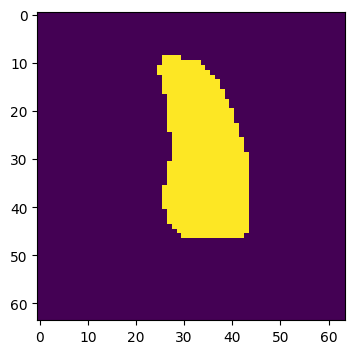

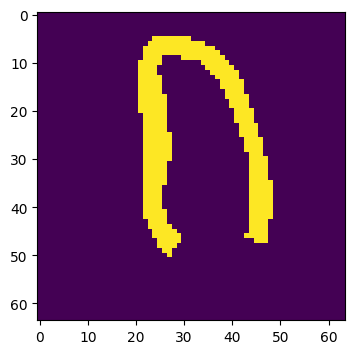

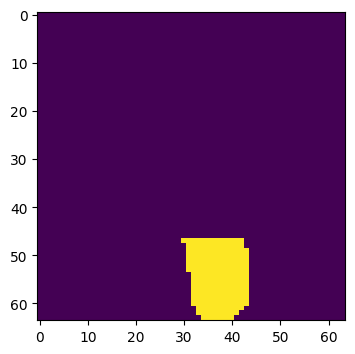

In [17]:
import SimpleITK as sitk

c_label_path = train_datalist[0]['label']

c_label = sitk.GetArrayFromImage(sitk.ReadImage(c_label_path))
plt.figure()
plt.imshow(c_label==1)

plt.figure()
plt.imshow(c_label==2)

plt.figure()
plt.imshow(c_label==3)

In [47]:
test_ds = CacheDataset(data=test_datalist, transform=test_transforms, cache_rate=1.0)
torch.unique(test_ds[0]['label'])

Loading dataset: 100%|██████████| 200/200 [00:01<00:00, 199.00it/s]


metatensor([0., 1., 2., 3.])

In [48]:
from monai.transforms import Transform, MapTransform

class DeleteLabelThreed(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)

    def __call__(self, data):
        d = dict(data)
        for key in self.key_iterator(d):
            if key == 'label':
                d[key] = torch.where(d[key]==3, 0, d[key])
        return d

In [49]:
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    LoadImaged,
    Resized,
    NormalizeIntensityd,
    
    RandAdjustContrastd,
    RandFlipd,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandRotated,
    RandScaleIntensityd,
    RandZoomd,
)

load_transforms = [
        LoadImaged(keys=["image", "label"], image_only=True),  # Load image and label
        EnsureChannelFirstd(keys=["image", "label"]),
    ]

transforms = Compose(load_transforms + [DeleteLabelThreed(['image','label'])])

In [50]:
test_ds = CacheDataset(data=test_datalist, transform=transforms, cache_rate=1.0)


Loading dataset: 100%|██████████| 200/200 [00:00<00:00, 230.78it/s]


In [51]:
torch.unique(test_ds[0]['label'])

metatensor([0., 1., 2.])

In [ ]:
c_label_path = train_datalist[0]['label']

c_label = sitk.GetArrayFromImage(sitk.ReadImage(s_label_path))
plt.figure()
plt.imshow(s_label==1)

plt.figure()
plt.imshow(s_label == 2)

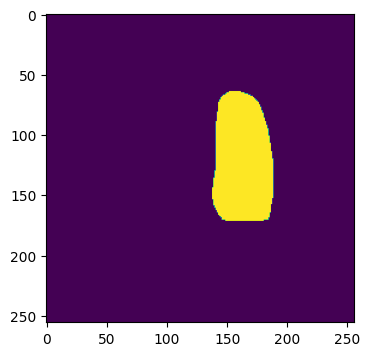

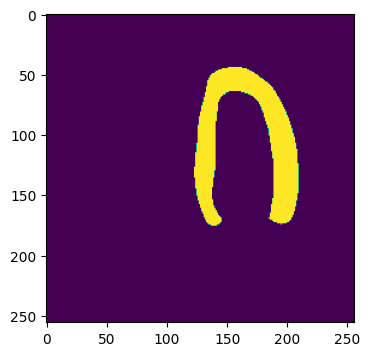

In [15]:

s_label_path = '../dataset/sumac_256/di-6C23-B944-CFE0/di-6C23-B944-CFE0_mask_ED.nii.gz'

s_label = sitk.GetArrayFromImage(sitk.ReadImage(s_label_path))
plt.figure()
plt.imshow(s_label==1)

plt.figure()
plt.imshow(s_label == 2)

In [6]:
print(train_datalist)

[{'image': 'C:\\Users\\user\\Desktop\\zhuyi\\PTI\\camus-hands-on-main\\camus_vae\\data\\camus_64\\patient0001\\patient0001_2CH_ED.nii.gz', 'label': 'C:\\Users\\user\\Desktop\\zhuyi\\PTI\\camus-hands-on-main\\camus_vae\\data\\camus_64\\patient0001\\patient0001_2CH_ED_gt.nii.gz'}, {'image': 'C:\\Users\\user\\Desktop\\zhuyi\\PTI\\camus-hands-on-main\\camus_vae\\data\\camus_64\\patient0001\\patient0001_2CH_ES.nii.gz', 'label': 'C:\\Users\\user\\Desktop\\zhuyi\\PTI\\camus-hands-on-main\\camus_vae\\data\\camus_64\\patient0001\\patient0001_2CH_ES_gt.nii.gz'}, {'image': 'C:\\Users\\user\\Desktop\\zhuyi\\PTI\\camus-hands-on-main\\camus_vae\\data\\camus_64\\patient0001\\patient0001_4CH_ED.nii.gz', 'label': 'C:\\Users\\user\\Desktop\\zhuyi\\PTI\\camus-hands-on-main\\camus_vae\\data\\camus_64\\patient0001\\patient0001_4CH_ED_gt.nii.gz'}, {'image': 'C:\\Users\\user\\Desktop\\zhuyi\\PTI\\camus-hands-on-main\\camus_vae\\data\\camus_64\\patient0001\\patient0001_4CH_ES.nii.gz', 'label': 'C:\\Users\\use

augmented_image          shape: (64, 64)              min:   -1.39760  max:    2.08685  float32
augmented_label          shape: (64, 64)              min:    0.00000  max:    3.00000  float32
label : [0. 1. 2. 3.]


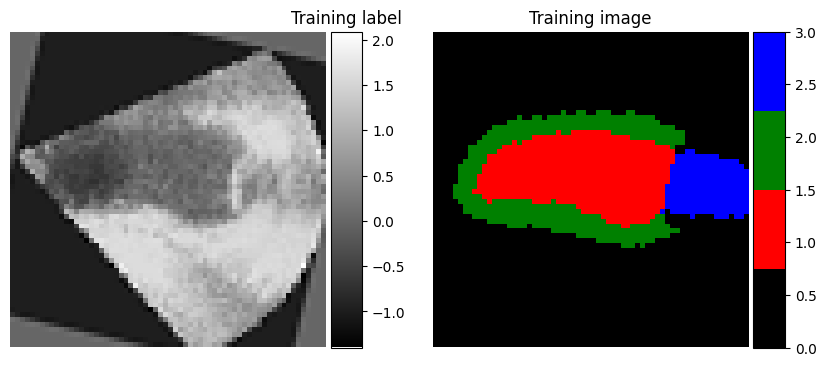

In [8]:
# Iterate over the dataset and get the first sample
ix = 0
first_sample = train_ds[ix]

# Extract the image from the sample
augmented_image = first_sample["image"].numpy().squeeze()
augmented_label = first_sample["label"].numpy().squeeze()
utils.log('augmented_image', augmented_image)
utils.log('augmented_label', augmented_label)
print(f'label : {np.unique(augmented_label)}')

fig, ax = plt.subplots(1,2, figsize=(2*5,1*5))
cmap = ListedColormap(["black", "red", "green", "blue"])
visu.imagesc(ax[0], augmented_image, title="Training image")
visu.imagesc(ax[1], augmented_label, title="Training label", colormap=cmap)
plt.show()

# Model (UNet)

In [9]:
model_dir = './experiments/20231215-Unet_CAMUS_pytorch'
os.makedirs(model_dir, exist_ok=True)

In [10]:
d = {
    # model
    'input_channels' : 1,
    'num_classes' : 4,
    'init_channels'  : 32,
    'use_bn' : True,
    'dropout' : 0.1,

    # experiment
    'learning_rate': 5e-3,
    'weight_decay' : 0,

    'num_epochs': 200,

    'model_dir' : model_dir,
    'save_best' : True,
    'restore_best' : True,
    'save_summary_steps' : 10,
  
     }
d['input_shape'] =  (d['input_channels'], args.IMG_SIZE, args.IMG_SIZE)
d['output_shape'] =  (d['num_classes'], args.IMG_SIZE, args.IMG_SIZE)
args.update(d)

for k,v in args.__dict__.items():
    print(f'{k:20} : {v}')

IMG_SIZE             : 64
device               : cuda
dtype                : torch.float32
batch_size           : 64
input_channels       : 1
num_classes          : 4
init_channels        : 32
use_bn               : True
dropout              : 0.1
learning_rate        : 0.005
weight_decay         : 0
num_epochs           : 200
model_dir            : ./experiments/20231215-Unet_CAMUS_pytorch
save_best            : True
restore_best         : True
save_summary_steps   : 10
input_shape          : (1, 64, 64)
output_shape         : (4, 64, 64)


In [11]:
from torchinfo import summary

unet = UNet(
         input_shape=args.input_shape, 
         output_shape=args.output_shape, 
         init_channels=args.init_channels,
         use_batchnorm=args.use_bn,
         dropout=args.dropout,
         )

unet = unet.to(device=args.device)

# # Print the summary of the network
summary_kwargs = dict(
   col_names = ["input_size", "output_size", "num_params"],
   depth = 2,
   verbose = 0,
)
input_shape = (10, 1, args.IMG_SIZE, args.IMG_SIZE)
summary(unet, input_shape, **summary_kwargs)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
UNet                                          [10, 1, 64, 64]           [10, 4, 64, 64]           --
├─_DoubleConv: 1-1                            [10, 1, 64, 64]           [10, 16, 64, 64]          --
│    └─Sequential: 2-1                        [10, 1, 64, 64]           [10, 16, 64, 64]          2,544
├─_Down: 1-2                                  [10, 16, 64, 64]          [10, 32, 32, 32]          --
│    └─Sequential: 2-2                        [10, 16, 64, 64]          [10, 32, 32, 32]          14,016
├─_Down: 1-3                                  [10, 32, 32, 32]          [10, 64, 16, 16]          --
│    └─Sequential: 2-3                        [10, 32, 32, 32]          [10, 64, 16, 16]          55,680
├─_Down: 1-4                                  [10, 64, 16, 16]          [10, 128, 8, 8]           --
│    └─Sequential: 2-4                        [10, 64, 16, 16]          [10

# Training

In [33]:
batch = next(iter(train_loader))
image_batch = batch['image'].to(device=args.device, dtype=args.dtype)
label_batch = batch['label'].to(device=args.device, dtype=torch.long)
logits_batch = unet(image_batch)
logits_batch.shape

torch.Size([64, 4, 64, 64])

In [46]:
# Set the random seed for reproducible experiments
torch.manual_seed(230)
if args.device == torch.device('cuda'):
    torch.cuda.manual_seed(230)

# Set the logger
utils.set_logger(os.path.join(model_dir, 'train.log'))

# Define the loss and optimizer
# Soft dice and CE loss function
loss_fn = DC_and_CE_loss(
    {"batch_dice": True, "smooth": 1e-5, "do_bg": False}, weight_ce=1, weight_dice=1
)

optimizer = optim.Adam(unet.parameters(), lr=args.learning_rate,
                       weight_decay=args.weight_decay)
# Train the model
logging.info("Starting training for {} epoch(s)".format(args.num_epochs))
history = train_and_evaluate(unet, train_loader, val_loader, optimizer, loss_fn,
                             net.metrics, args, restore_file=None)

Starting training for 200 epoch(s)
Epoch 1/200
100%|██████████| 25/25 [00:09<00:00,  2.55it/s, loss=0.298]
- Train metrics: dice: 0.349 ; loss: 0.533
- Eval metrics : dice: 0.259 ; loss: 2.207
- Found new best accuracy
Epoch 2/200


checkpoint saved to ./experiments/20231215-Unet_CAMUS_pytorch\so_far_best_model.pth


100%|██████████| 25/25 [00:09<00:00,  2.65it/s, loss=-0.365]
- Train metrics: dice: 0.707 ; loss: -0.341
- Eval metrics : dice: 0.785 ; loss: -0.495
- Found new best accuracy
Epoch 3/200


checkpoint saved to ./experiments/20231215-Unet_CAMUS_pytorch\so_far_best_model.pth


100%|██████████| 25/25 [00:10<00:00,  2.42it/s, loss=-0.571]
- Train metrics: dice: 0.799 ; loss: -0.559
- Eval metrics : dice: 0.819 ; loss: -0.625
- Found new best accuracy
Epoch 4/200


checkpoint saved to ./experiments/20231215-Unet_CAMUS_pytorch\so_far_best_model.pth


100%|██████████| 25/25 [00:10<00:00,  2.41it/s, loss=-0.628]
- Train metrics: dice: 0.825 ; loss: -0.631
- Eval metrics : dice: 0.844 ; loss: -0.676
- Found new best accuracy
Epoch 5/200


checkpoint saved to ./experiments/20231215-Unet_CAMUS_pytorch\so_far_best_model.pth


100%|██████████| 25/25 [00:10<00:00,  2.37it/s, loss=-0.645]
- Train metrics: dice: 0.820 ; loss: -0.628
- Eval metrics : dice: 0.845 ; loss: -0.682
- Found new best accuracy
Epoch 6/200


checkpoint saved to ./experiments/20231215-Unet_CAMUS_pytorch\so_far_best_model.pth


100%|██████████| 25/25 [00:11<00:00,  2.20it/s, loss=-0.669]
- Train metrics: dice: 0.845 ; loss: -0.666
- Eval metrics : dice: 0.831 ; loss: -0.661
Epoch 7/200
100%|██████████| 25/25 [00:10<00:00,  2.32it/s, loss=-0.677]
- Train metrics: dice: 0.846 ; loss: -0.681
- Eval metrics : dice: 0.840 ; loss: -0.675
Epoch 8/200
100%|██████████| 25/25 [00:11<00:00,  2.19it/s, loss=-0.684]
- Train metrics: dice: 0.845 ; loss: -0.682
- Eval metrics : dice: 0.850 ; loss: -0.696
- Found new best accuracy
Epoch 9/200


checkpoint saved to ./experiments/20231215-Unet_CAMUS_pytorch\so_far_best_model.pth


100%|██████████| 25/25 [00:12<00:00,  2.04it/s, loss=-0.698]
- Train metrics: dice: 0.855 ; loss: -0.692
- Eval metrics : dice: 0.834 ; loss: -0.664
Epoch 10/200
100%|██████████| 25/25 [00:10<00:00,  2.44it/s, loss=-0.701]
- Train metrics: dice: 0.853 ; loss: -0.697
- Eval metrics : dice: 0.851 ; loss: -0.704
- Found new best accuracy
Epoch 11/200


checkpoint saved to ./experiments/20231215-Unet_CAMUS_pytorch\so_far_best_model.pth


100%|██████████| 25/25 [00:10<00:00,  2.37it/s, loss=-0.708]
- Train metrics: dice: 0.863 ; loss: -0.712
- Eval metrics : dice: 0.862 ; loss: -0.720
- Found new best accuracy
Epoch 12/200


checkpoint saved to ./experiments/20231215-Unet_CAMUS_pytorch\so_far_best_model.pth


100%|██████████| 25/25 [00:09<00:00,  2.57it/s, loss=-0.712]
- Train metrics: dice: 0.863 ; loss: -0.724
- Eval metrics : dice: 0.861 ; loss: -0.715
Epoch 13/200
100%|██████████| 25/25 [00:09<00:00,  2.57it/s, loss=-0.715]
- Train metrics: dice: 0.863 ; loss: -0.713
- Eval metrics : dice: 0.860 ; loss: -0.713
Epoch 14/200
100%|██████████| 25/25 [00:09<00:00,  2.59it/s, loss=-0.718]
- Train metrics: dice: 0.857 ; loss: -0.708
- Eval metrics : dice: 0.857 ; loss: -0.712
Epoch 15/200
100%|██████████| 25/25 [00:10<00:00,  2.48it/s, loss=-0.717]
- Train metrics: dice: 0.858 ; loss: -0.709
- Eval metrics : dice: 0.857 ; loss: -0.708
Epoch 16/200
100%|██████████| 25/25 [00:09<00:00,  2.57it/s, loss=-0.726]
- Train metrics: dice: 0.870 ; loss: -0.730
- Eval metrics : dice: 0.848 ; loss: -0.701
Epoch 17/200
100%|██████████| 25/25 [00:10<00:00,  2.50it/s, loss=-0.727]
- Train metrics: dice: 0.869 ; loss: -0.730
- Eval metrics : dice: 0.861 ; loss: -0.717
Epoch 18/200
100%|██████████| 25/25 [00:0

checkpoint saved to ./experiments/20231215-Unet_CAMUS_pytorch\so_far_best_model.pth


100%|██████████| 25/25 [00:09<00:00,  2.54it/s, loss=-0.740]
- Train metrics: dice: 0.873 ; loss: -0.738
- Eval metrics : dice: 0.853 ; loss: -0.706
Epoch 20/200
100%|██████████| 25/25 [00:09<00:00,  2.52it/s, loss=-0.738]
- Train metrics: dice: 0.868 ; loss: -0.729
- Eval metrics : dice: 0.873 ; loss: -0.744
- Found new best accuracy
Epoch 21/200


checkpoint saved to ./experiments/20231215-Unet_CAMUS_pytorch\so_far_best_model.pth


100%|██████████| 25/25 [00:10<00:00,  2.39it/s, loss=-0.743]
- Train metrics: dice: 0.878 ; loss: -0.744
- Eval metrics : dice: 0.872 ; loss: -0.738
Epoch 22/200
100%|██████████| 25/25 [00:10<00:00,  2.44it/s, loss=-0.746]
- Train metrics: dice: 0.879 ; loss: -0.746
- Eval metrics : dice: 0.866 ; loss: -0.736
Epoch 23/200
100%|██████████| 25/25 [00:10<00:00,  2.42it/s, loss=-0.747]
- Train metrics: dice: 0.875 ; loss: -0.747
- Eval metrics : dice: 0.873 ; loss: -0.748
Epoch 24/200
100%|██████████| 25/25 [00:09<00:00,  2.53it/s, loss=-0.747]
- Train metrics: dice: 0.877 ; loss: -0.752
- Eval metrics : dice: 0.867 ; loss: -0.729
Epoch 25/200
100%|██████████| 25/25 [00:09<00:00,  2.70it/s, loss=-0.756]
- Train metrics: dice: 0.875 ; loss: -0.750
- Eval metrics : dice: 0.859 ; loss: -0.721
Epoch 26/200
100%|██████████| 25/25 [00:09<00:00,  2.66it/s, loss=-0.746]
- Train metrics: dice: 0.881 ; loss: -0.753
- Eval metrics : dice: 0.860 ; loss: -0.725
Epoch 27/200
100%|██████████| 25/25 [00:0

checkpoint saved to ./experiments/20231215-Unet_CAMUS_pytorch\so_far_best_model.pth


100%|██████████| 25/25 [00:09<00:00,  2.64it/s, loss=-0.747]
- Train metrics: dice: 0.869 ; loss: -0.737
- Eval metrics : dice: 0.871 ; loss: -0.751
Epoch 29/200
100%|██████████| 25/25 [00:07<00:00,  3.35it/s, loss=-0.753]
- Train metrics: dice: 0.876 ; loss: -0.753
- Eval metrics : dice: 0.877 ; loss: -0.759
- Found new best accuracy
Epoch 30/200


checkpoint saved to ./experiments/20231215-Unet_CAMUS_pytorch\so_far_best_model.pth


100%|██████████| 25/25 [00:07<00:00,  3.31it/s, loss=-0.760]
- Train metrics: dice: 0.880 ; loss: -0.756
- Eval metrics : dice: 0.879 ; loss: -0.762
- Found new best accuracy
Epoch 31/200


checkpoint saved to ./experiments/20231215-Unet_CAMUS_pytorch\so_far_best_model.pth


100%|██████████| 25/25 [00:07<00:00,  3.15it/s, loss=-0.760]
- Train metrics: dice: 0.880 ; loss: -0.753
- Eval metrics : dice: 0.870 ; loss: -0.747
Epoch 32/200
100%|██████████| 25/25 [00:09<00:00,  2.68it/s, loss=-0.763]
- Train metrics: dice: 0.887 ; loss: -0.764
- Eval metrics : dice: 0.869 ; loss: -0.740
Epoch 33/200
100%|██████████| 25/25 [00:07<00:00,  3.19it/s, loss=-0.758]
- Train metrics: dice: 0.884 ; loss: -0.762
- Eval metrics : dice: 0.874 ; loss: -0.753
Epoch 34/200
100%|██████████| 25/25 [00:07<00:00,  3.25it/s, loss=-0.763]
- Train metrics: dice: 0.886 ; loss: -0.765
- Eval metrics : dice: 0.882 ; loss: -0.761
- Found new best accuracy
Epoch 35/200


checkpoint saved to ./experiments/20231215-Unet_CAMUS_pytorch\so_far_best_model.pth


100%|██████████| 25/25 [00:07<00:00,  3.24it/s, loss=-0.769]
- Train metrics: dice: 0.881 ; loss: -0.762
- Eval metrics : dice: 0.877 ; loss: -0.757
Epoch 36/200
100%|██████████| 25/25 [00:07<00:00,  3.15it/s, loss=-0.769]
- Train metrics: dice: 0.883 ; loss: -0.757
- Eval metrics : dice: 0.877 ; loss: -0.755
Epoch 37/200
100%|██████████| 25/25 [00:07<00:00,  3.40it/s, loss=-0.774]
- Train metrics: dice: 0.890 ; loss: -0.777
- Eval metrics : dice: 0.882 ; loss: -0.768
- Found new best accuracy
Epoch 38/200


checkpoint saved to ./experiments/20231215-Unet_CAMUS_pytorch\so_far_best_model.pth


100%|██████████| 25/25 [00:07<00:00,  3.37it/s, loss=-0.770]
- Train metrics: dice: 0.888 ; loss: -0.777
- Eval metrics : dice: 0.870 ; loss: -0.741
Epoch 39/200
100%|██████████| 25/25 [00:07<00:00,  3.39it/s, loss=-0.772]
- Train metrics: dice: 0.883 ; loss: -0.761
- Eval metrics : dice: 0.878 ; loss: -0.759
Epoch 40/200
100%|██████████| 25/25 [00:07<00:00,  3.40it/s, loss=-0.774]
- Train metrics: dice: 0.888 ; loss: -0.776
- Eval metrics : dice: 0.872 ; loss: -0.739
Epoch 41/200
100%|██████████| 25/25 [00:07<00:00,  3.40it/s, loss=-0.774]
- Train metrics: dice: 0.895 ; loss: -0.783
- Eval metrics : dice: 0.882 ; loss: -0.760
Epoch 42/200
100%|██████████| 25/25 [00:07<00:00,  3.52it/s, loss=-0.777]
- Train metrics: dice: 0.891 ; loss: -0.774
- Eval metrics : dice: 0.875 ; loss: -0.745
Epoch 43/200
100%|██████████| 25/25 [00:07<00:00,  3.49it/s, loss=-0.772]
- Train metrics: dice: 0.885 ; loss: -0.767
- Eval metrics : dice: 0.878 ; loss: -0.763
Epoch 44/200
100%|██████████| 25/25 [00:0

checkpoint saved to ./experiments/20231215-Unet_CAMUS_pytorch\so_far_best_model.pth


100%|██████████| 25/25 [00:07<00:00,  3.48it/s, loss=-0.788]
- Train metrics: dice: 0.894 ; loss: -0.780
- Eval metrics : dice: 0.883 ; loss: -0.765
- Found new best accuracy
Epoch 51/200


checkpoint saved to ./experiments/20231215-Unet_CAMUS_pytorch\so_far_best_model.pth


100%|██████████| 25/25 [00:07<00:00,  3.42it/s, loss=-0.786]
- Train metrics: dice: 0.895 ; loss: -0.784
- Eval metrics : dice: 0.878 ; loss: -0.753
Epoch 52/200
100%|██████████| 25/25 [00:07<00:00,  3.40it/s, loss=-0.784]
- Train metrics: dice: 0.895 ; loss: -0.788
- Eval metrics : dice: 0.875 ; loss: -0.750
Epoch 53/200
100%|██████████| 25/25 [00:07<00:00,  3.38it/s, loss=-0.784]
- Train metrics: dice: 0.896 ; loss: -0.789
- Eval metrics : dice: 0.885 ; loss: -0.769
- Found new best accuracy
Epoch 54/200


checkpoint saved to ./experiments/20231215-Unet_CAMUS_pytorch\so_far_best_model.pth


100%|██████████| 25/25 [00:06<00:00,  3.62it/s, loss=-0.785]
- Train metrics: dice: 0.893 ; loss: -0.781
- Eval metrics : dice: 0.879 ; loss: -0.755
Epoch 55/200
100%|██████████| 25/25 [00:07<00:00,  3.52it/s, loss=-0.786]
- Train metrics: dice: 0.896 ; loss: -0.787
- Eval metrics : dice: 0.883 ; loss: -0.764
Epoch 56/200
100%|██████████| 25/25 [00:06<00:00,  3.58it/s, loss=-0.789]
- Train metrics: dice: 0.899 ; loss: -0.793
- Eval metrics : dice: 0.876 ; loss: -0.748
Epoch 57/200
100%|██████████| 25/25 [00:07<00:00,  3.48it/s, loss=-0.786]
- Train metrics: dice: 0.898 ; loss: -0.792
- Eval metrics : dice: 0.879 ; loss: -0.761
Epoch 58/200
100%|██████████| 25/25 [00:06<00:00,  3.58it/s, loss=-0.790]
- Train metrics: dice: 0.887 ; loss: -0.780
- Eval metrics : dice: 0.875 ; loss: -0.742
Epoch 59/200
100%|██████████| 25/25 [00:06<00:00,  3.68it/s, loss=-0.788]
- Train metrics: dice: 0.892 ; loss: -0.781
- Eval metrics : dice: 0.869 ; loss: -0.727
Epoch 60/200
100%|██████████| 25/25 [00:0

checkpoint saved to ./experiments/20231215-Unet_CAMUS_pytorch\so_far_best_model.pth


100%|██████████| 25/25 [00:07<00:00,  3.48it/s, loss=-0.797]
- Train metrics: dice: 0.899 ; loss: -0.798
- Eval metrics : dice: 0.882 ; loss: -0.762
Epoch 68/200
100%|██████████| 25/25 [00:07<00:00,  3.51it/s, loss=-0.802]
- Train metrics: dice: 0.903 ; loss: -0.797
- Eval metrics : dice: 0.888 ; loss: -0.780
- Found new best accuracy
Epoch 69/200


checkpoint saved to ./experiments/20231215-Unet_CAMUS_pytorch\so_far_best_model.pth


100%|██████████| 25/25 [00:07<00:00,  3.30it/s, loss=-0.794]
- Train metrics: dice: 0.894 ; loss: -0.789
- Eval metrics : dice: 0.885 ; loss: -0.768
Epoch 70/200
100%|██████████| 25/25 [00:07<00:00,  3.47it/s, loss=-0.800]
- Train metrics: dice: 0.901 ; loss: -0.801
- Eval metrics : dice: 0.884 ; loss: -0.769
Epoch 71/200
100%|██████████| 25/25 [00:07<00:00,  3.49it/s, loss=-0.791]
- Train metrics: dice: 0.900 ; loss: -0.797
- Eval metrics : dice: 0.886 ; loss: -0.774
Epoch 72/200
100%|██████████| 25/25 [00:07<00:00,  3.53it/s, loss=-0.793]
- Train metrics: dice: 0.896 ; loss: -0.788
- Eval metrics : dice: 0.880 ; loss: -0.761
Epoch 73/200
100%|██████████| 25/25 [00:07<00:00,  3.52it/s, loss=-0.795]
- Train metrics: dice: 0.899 ; loss: -0.798
- Eval metrics : dice: 0.877 ; loss: -0.761
Epoch 74/200
100%|██████████| 25/25 [00:06<00:00,  3.62it/s, loss=-0.797]
- Train metrics: dice: 0.898 ; loss: -0.792
- Eval metrics : dice: 0.889 ; loss: -0.775
- Found new best accuracy
Epoch 75/200


checkpoint saved to ./experiments/20231215-Unet_CAMUS_pytorch\so_far_best_model.pth


100%|██████████| 25/25 [00:06<00:00,  3.66it/s, loss=-0.796]
- Train metrics: dice: 0.901 ; loss: -0.794
- Eval metrics : dice: 0.880 ; loss: -0.764
Epoch 76/200
100%|██████████| 25/25 [00:07<00:00,  3.45it/s, loss=-0.804]
- Train metrics: dice: 0.902 ; loss: -0.803
- Eval metrics : dice: 0.886 ; loss: -0.775
Epoch 77/200
100%|██████████| 25/25 [00:07<00:00,  3.51it/s, loss=-0.801]
- Train metrics: dice: 0.897 ; loss: -0.797
- Eval metrics : dice: 0.887 ; loss: -0.772
Epoch 78/200
100%|██████████| 25/25 [00:07<00:00,  3.50it/s, loss=-0.804]
- Train metrics: dice: 0.902 ; loss: -0.799
- Eval metrics : dice: 0.884 ; loss: -0.772
Epoch 79/200
100%|██████████| 25/25 [00:07<00:00,  3.52it/s, loss=-0.802]
- Train metrics: dice: 0.905 ; loss: -0.809
- Eval metrics : dice: 0.881 ; loss: -0.761
Epoch 80/200
100%|██████████| 25/25 [00:06<00:00,  3.63it/s, loss=-0.806]
- Train metrics: dice: 0.909 ; loss: -0.812
- Eval metrics : dice: 0.885 ; loss: -0.767
Epoch 81/200
100%|██████████| 25/25 [00:0

checkpoint saved to ./experiments/20231215-Unet_CAMUS_pytorch\so_far_best_model.pth


100%|██████████| 25/25 [00:06<00:00,  3.63it/s, loss=-0.809]
- Train metrics: dice: 0.905 ; loss: -0.805
- Eval metrics : dice: 0.886 ; loss: -0.768
Epoch 83/200
100%|██████████| 25/25 [00:07<00:00,  3.47it/s, loss=-0.806]
- Train metrics: dice: 0.903 ; loss: -0.803
- Eval metrics : dice: 0.882 ; loss: -0.764
Epoch 84/200
100%|██████████| 25/25 [00:06<00:00,  3.77it/s, loss=-0.810]
- Train metrics: dice: 0.906 ; loss: -0.814
- Eval metrics : dice: 0.888 ; loss: -0.777
Epoch 85/200
100%|██████████| 25/25 [00:07<00:00,  3.57it/s, loss=-0.796]
- Train metrics: dice: 0.898 ; loss: -0.794
- Eval metrics : dice: 0.876 ; loss: -0.748
Epoch 86/200
100%|██████████| 25/25 [00:07<00:00,  3.36it/s, loss=-0.802]
- Train metrics: dice: 0.898 ; loss: -0.794
- Eval metrics : dice: 0.881 ; loss: -0.759
Epoch 87/200
100%|██████████| 25/25 [00:07<00:00,  3.40it/s, loss=-0.798]
- Train metrics: dice: 0.905 ; loss: -0.802
- Eval metrics : dice: 0.885 ; loss: -0.768
Epoch 88/200
100%|██████████| 25/25 [00:0

checkpoint saved to ./experiments/20231215-Unet_CAMUS_pytorch\so_far_best_model.pth


100%|██████████| 25/25 [00:07<00:00,  3.57it/s, loss=-0.810]
- Train metrics: dice: 0.905 ; loss: -0.810
- Eval metrics : dice: 0.887 ; loss: -0.773
Epoch 93/200
100%|██████████| 25/25 [00:07<00:00,  3.55it/s, loss=-0.807]
- Train metrics: dice: 0.903 ; loss: -0.807
- Eval metrics : dice: 0.886 ; loss: -0.770
Epoch 94/200
100%|██████████| 25/25 [00:07<00:00,  3.48it/s, loss=-0.812]
- Train metrics: dice: 0.906 ; loss: -0.810
- Eval metrics : dice: 0.889 ; loss: -0.777
Epoch 95/200
100%|██████████| 25/25 [00:07<00:00,  3.56it/s, loss=-0.815]
- Train metrics: dice: 0.907 ; loss: -0.811
- Eval metrics : dice: 0.887 ; loss: -0.775
Epoch 96/200
100%|██████████| 25/25 [00:07<00:00,  3.43it/s, loss=-0.814]
- Train metrics: dice: 0.905 ; loss: -0.814
- Eval metrics : dice: 0.885 ; loss: -0.768
Epoch 97/200
100%|██████████| 25/25 [00:06<00:00,  3.58it/s, loss=-0.810]
- Train metrics: dice: 0.905 ; loss: -0.809
- Eval metrics : dice: 0.884 ; loss: -0.765
Epoch 98/200
100%|██████████| 25/25 [00:0

KeyboardInterrupt: 

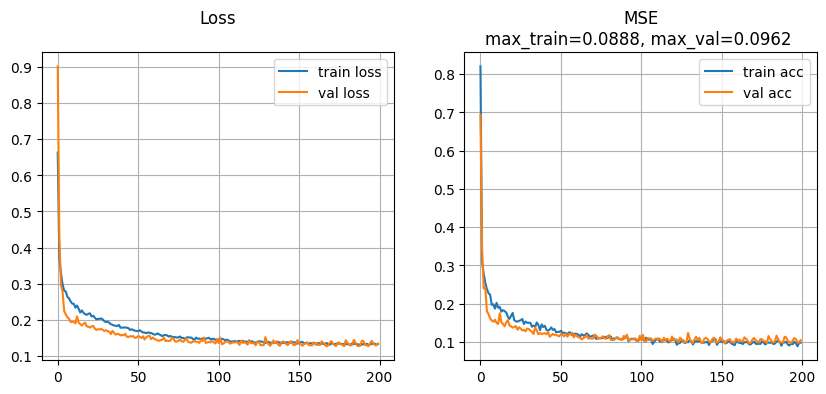

In [92]:
epoch_lim = args.num_epochs

tr_loss, val_loss, tr_mse, val_mse = history['train_loss'],history['val_loss'],\
                                     history['train_mse'],history['val_mse']
factor = 0.5
rows, cols = 1, 2
fig, ax = plt.subplots(rows,cols,figsize=(cols*factor*10, rows*factor*8))
ax[0].plot(tr_loss[:epoch_lim],label='train loss')
ax[0].plot(val_loss[:epoch_lim],label='val loss')
ax[0].legend()
ax[0].grid()
title = 'Loss\n'
ax[0].set_title(title)

ax[1].plot(tr_mse,label='train acc')
ax[1].plot(val_mse,label='val acc')
ax[1].legend()
ax[1].grid()
title = 'MSE\n'
title += f'max_train={min(tr_mse):.4f}, max_val={min(val_mse):.4f} '
ax[1].set_title(title)
plt.show()

## Save the model (and load)

In [47]:
model_path = os.path.join(model_dir, '20231215-UNet-pytorch.pth')
assert not os.path.exists(model_path),'model already exists, you really want to overwrite it?'
torch.save(unet.state_dict(), model_path)


# Load the model

In [12]:
# model_path = os.path.join('./model', 'pretrained_best_model_50epochs.pth')
model_path = './experiments/20231215-Unet_CAMUS_pytorch/so_far_best_model.pth'
weight = torch.load(model_path, map_location=args.device)
unet.load_state_dict(weight)  # ['model_state_dict']
unet.to(args.device)

UNet(
  (layer1): _DoubleConv(
    (net): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.05, inplace=False)
      (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): Dropout(p=0.05, inplace=False)
    )
  )
  (layer2): _Down(
    (net): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): _DoubleConv(
        (net): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Dropout(p=0.1, inplace=False)
          (4): Conv2d(3

In [16]:
metric_per_class = weight["metric_per_class"]
best_metric_epoch = weight["best_metric_epoch"]

print('Dice on validation set : ')
print('--------------------------------')
for i, label_name in enumerate(["left ventricle", "myocardium", "left atrium"]):
    best_metric_value = metric_per_class[f'metric/{i+1}'][best_metric_epoch]
    print(f'{label_name:20} : {best_metric_value*100:.2f} %')

Dice on validation set : 
--------------------------------
left ventricle       : 92.78 %
myocardium           : 86.07 %
left atrium          : 90.28 %


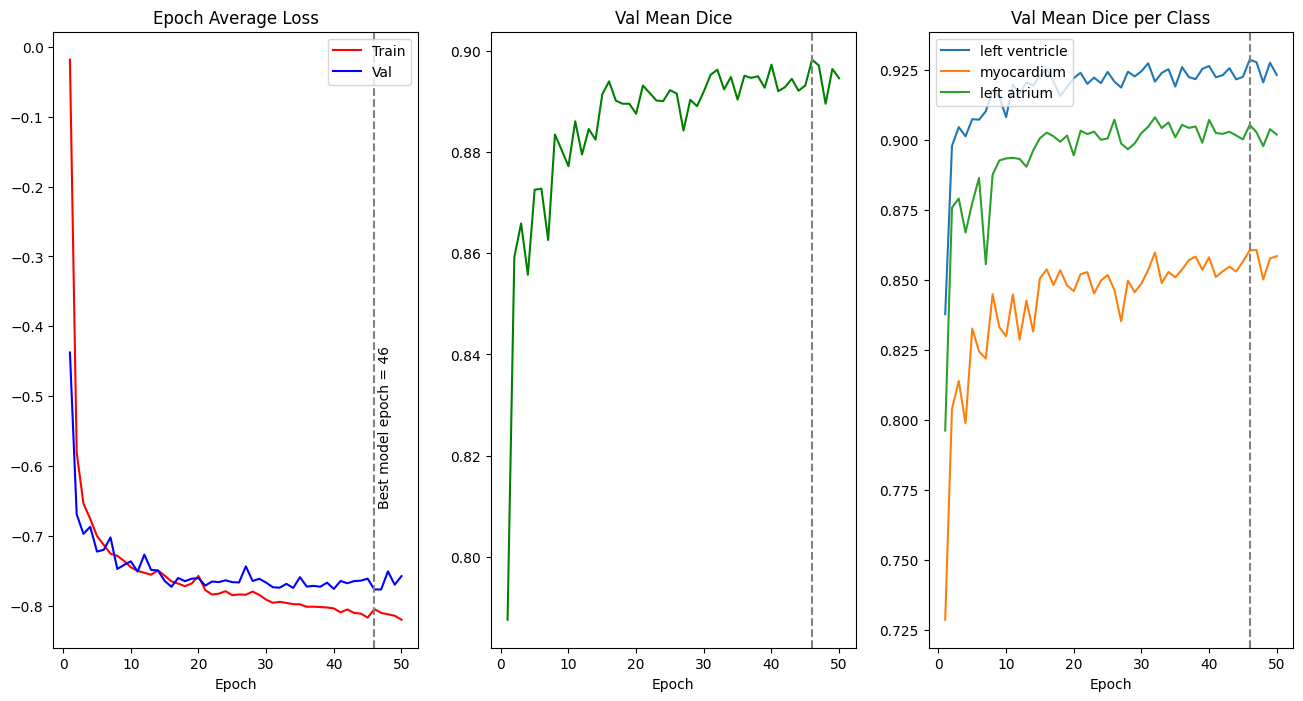

In [169]:
# epoch_train_loss_values = weight["train_loss"]
# epoch_val_loss_values = weight["val_loss"]
# epoch_val = weight["epoch_val"]
# metric_values = weight["metric_values"]
# metric_per_class = weight["metric_per_class"]
# max_epochs = weight["max_epochs"]
# best_metric_epoch = weight["best_metric_epoch"]

# # Plot the training losses, validation losses and validation dice over epochs
# trains_epoch = list(range(1, max_epochs + 1, 1))
# vals_epochs = epoch_val

# plt.figure("train", (16, 8))
# ax = plt.subplot(1, 3, 1)
# plt.title("Epoch Average Loss")
# plt.xlabel("Epoch")
# # ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
# plt.plot(trains_epoch, epoch_train_loss_values, color="red", label="Train")
# plt.plot(vals_epochs, epoch_val_loss_values, color="blue", label="Val")
# # Add a vertical line at the best model epoch
# plt.axvline(best_metric_epoch, color="gray", linestyle="--")
# plt.text(
#     best_metric_epoch + 0.5,
#     min(epoch_train_loss_values) * 4 / 5,
#     f"Best model epoch = {best_metric_epoch}",
#     rotation=90,
# )
# plt.legend(loc="upper right")
# ax = plt.subplot(1, 3, 2)
# plt.title("Val Mean Dice")
# plt.xlabel("Epoch")
# # ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
# plt.plot(vals_epochs, metric_values, color="green")
# plt.axvline(best_metric_epoch, color="gray", linestyle="--")

# ax = plt.subplot(1, 3, 3)
# plt.title("Val Mean Dice per Class")
# plt.xlabel("Epoch")
# # ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
# legend_metric = ["left ventricle", "myocardium", "left atrium"]
# for i in range(1, args.num_classes, 1):
#     plt.plot(vals_epochs, metric_per_class[f"metric/{i}"], label=legend_metric[i - 1])
# plt.axvline(best_metric_epoch, color="gray", linestyle="--")
# plt.legend(loc="upper left")
# plt.show()

# Inference CAMUS

In [13]:
from cs230.evaluate import evaluate
from cs230.evaluate import predict_unet

loss_fn = DC_and_CE_loss(
    {"batch_dice": True, "smooth": 1e-5, "do_bg": False}, weight_ce=1, weight_dice=1
)

# Evaluation on test set
loss_metric = evaluate(unet, loss_fn, test_loader, net.metrics, args)
print(loss_metric)

# Prediction on test set
out_dict = predict_unet(test_loader, unet, args)

for k, v in out_dict.items():
    utils.log(k, v)

{'dice': 0.8827647417783737, 'loss': -0.7589362412691116}


100%|██████████| 4/4 [00:00<00:00, 38.12it/s]

all_imgs                 shape: (200, 1, 64, 64)      min:   -1.04597  max:    6.47483  float32
all_labs                 shape: (200, 1, 64, 64)      min:    0.00000  max:    3.00000  float32
all_segs                 shape: (200, 64, 64)         min:    0.00000  max:    3.00000  int64


img                      shape: (4, 64, 64, 1)        min:   -0.93222  max:    4.59530  float32
gt                       shape: (4, 64, 64)           min:    0.00000  max:    3.00000  float32
seg                      shape: (4, 64, 64)           min:    0.00000  max:    3.00000  int64


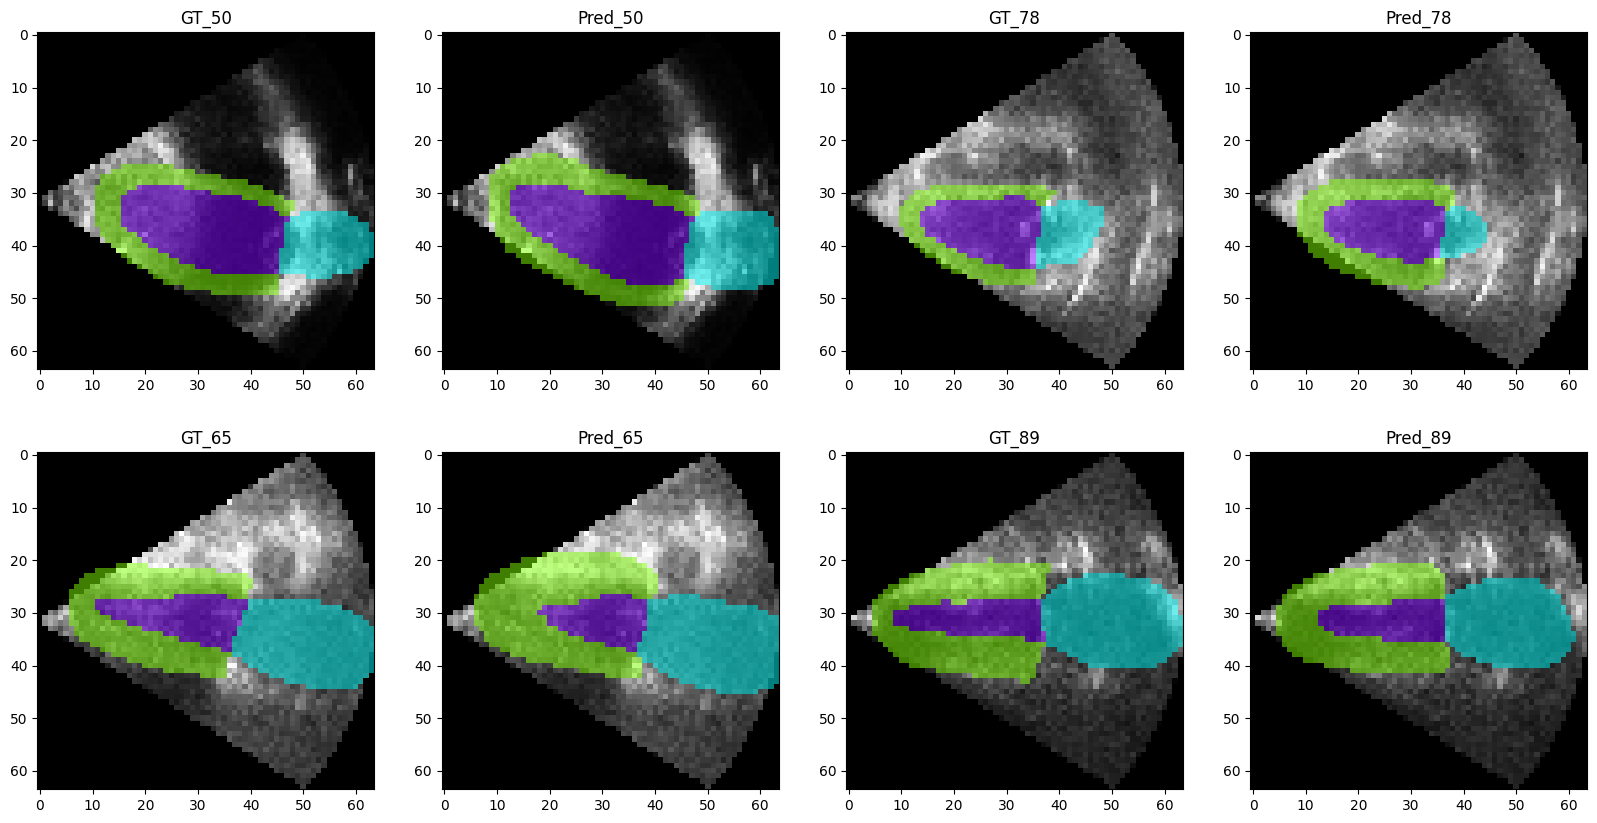

In [14]:
nb_show = 4
cs = 4
alpha = 0.5
show_mask = True
show_contours = False


ixs = np.random.choice(len(out_dict['all_imgs']), nb_show, replace=False)
imgs = out_dict['all_imgs'][ixs].transpose(0,2,3,1)
gts = out_dict['all_labs'][ixs].squeeze()
segs = out_dict['all_segs'][ixs]

utils.log('img',imgs)
utils.log('gt',gts)
utils.log('seg',segs)

rs = (nb_show*2 + cs-1 ) // cs
fig, ax = plt.subplots(rs, cs, figsize=(cs * 5, rs * 5))
ax = ax.ravel()

colors = [ c + (alpha, ) for c in visu.random_colors(args.num_classes)]

for i, (img, gt, seg) in enumerate(zip(imgs, gts, segs)):
    visu.plot_overlay_segmentation(img, gt, args.num_classes, colors=colors, ax=ax[2*i], title=f'GT_{ixs[i]}',
                                   show_mask=show_mask, show_contours=show_contours)
    visu.plot_overlay_segmentation(img, seg, args.num_classes, colors=colors, ax=ax[2*i + 1], title=f'Pred_{ixs[i]}',
                                   show_mask=show_mask, show_contours=show_contours)

img                      shape: (8, 64, 64, 1)        min:   -0.95148  max:    5.19743  float32
gt                       shape: (8, 64, 64)           min:    0.00000  max:    3.00000  float32
seg                      shape: (8, 64, 64)           min:    0.00000  max:    3.00000  int64


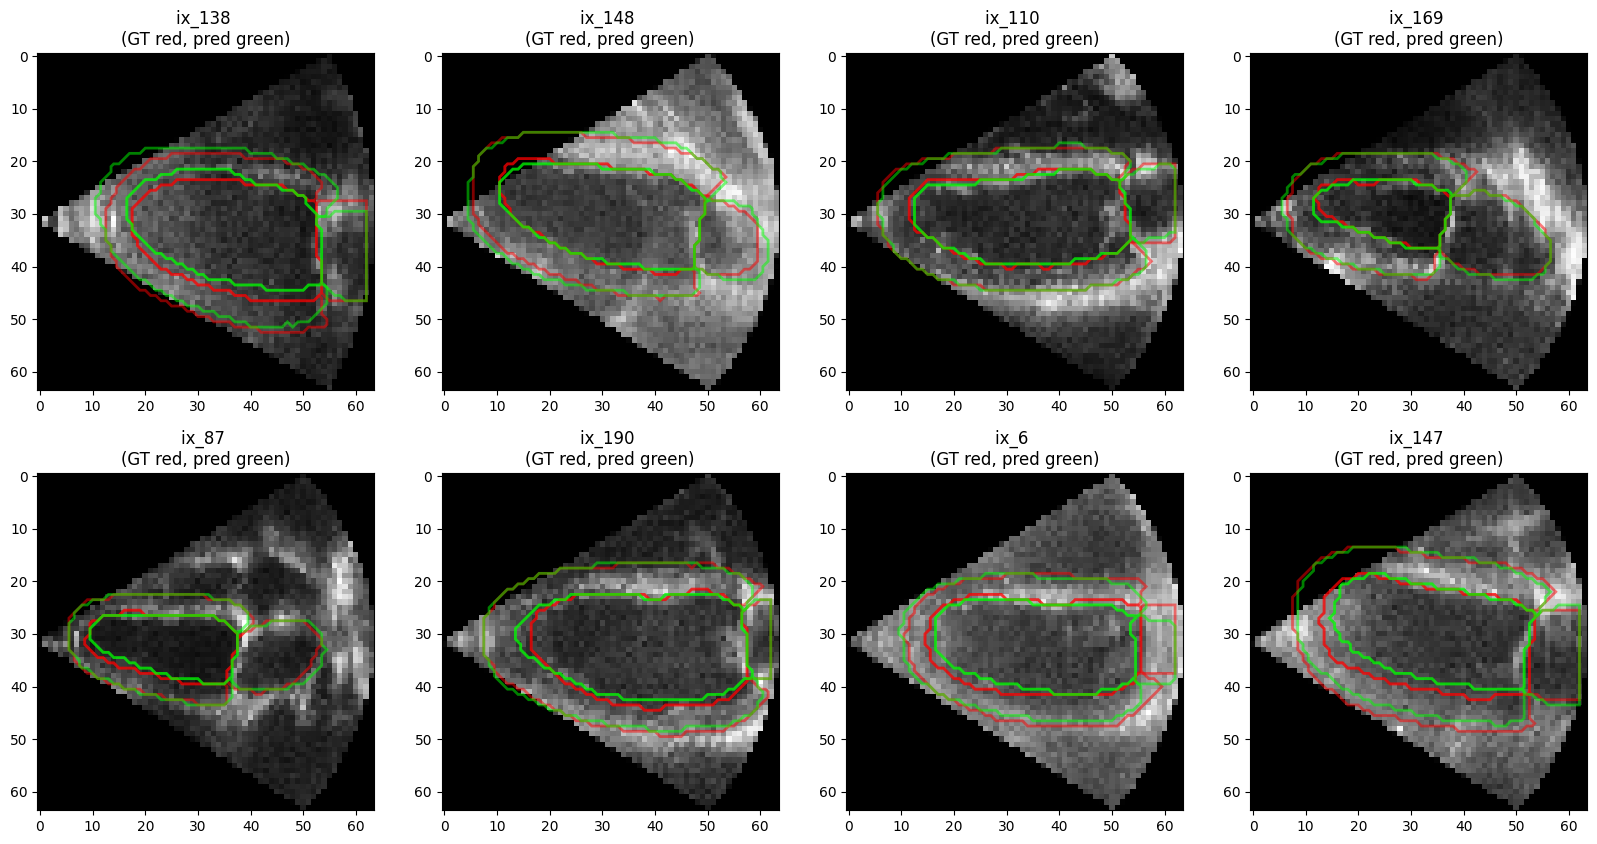

In [15]:
nb_show = 8
cs = 4

ixs = np.random.choice(len(out_dict['all_imgs']), nb_show, replace=False)
imgs = out_dict['all_imgs'][ixs].transpose(0,2,3,1)
gts = out_dict['all_labs'][ixs].squeeze()
segs = out_dict['all_segs'][ixs]

utils.log('img',imgs)
utils.log('gt',gts)
utils.log('seg',segs)

rs = (nb_show + cs-1 ) // cs
fig, ax = plt.subplots(rs, cs, figsize=(cs * 5, rs * 5))
ax = ax.ravel()

gt_colors = [ (1, 0, 0, 0.5) for _ in range(args.num_classes)]
pred_colors = [ (0, 1, 0, 0.5) for _ in range(args.num_classes)]

for i, (img, gt, seg) in enumerate(zip(imgs, gts, segs)):
    visu.plot_overlay_segmentation(img, gt, args.num_classes, colors=gt_colors, ax=ax[i],
                                   show_mask=False, show_contours=True)
    visu.plot_overlay_segmentation(img, seg, args.num_classes, colors=pred_colors, ax=ax[i], title=f'ix_{ixs[i]} \n(GT red, pred green)',
                                   show_mask=False, show_contours=True)

## Evaluation

In [16]:
label_ix_to_name = {1 : "VG", 2 : "MC", 3 : "OG"}
# VG = ventricule gauche, MC = muscle cardiaque, OG = oreillette gauche
metrics_dict = {
                'Dice' : {'func' : dice_coeff_single_img_single_label, 'kwargs': {}},
                'HD'   : {'func' : hd, 'kwargs': {'voxelspacing' : [1., 1.]}},
                'ASSD' : {'func' : assd, 'kwargs': {'voxelspacing' : [1., 1.]}},
}
################################################################

# Convert dense matrix to one-hot representation
# all_labels = torch.from_numpy(out_dict['all_labs'])
# all_labels = F.one_hot(all_labels.long(), args.num_classes).squeeze()
# all_labels = all_labels.permute(0, 3, 1, 2).float() # (N,H,W,C) -> (N,C,H,W)
# all_labels = all_labels.detach().cpu().numpy()
all_labels = utils.one_hot_numpy(out_dict['all_labs'].astype(int).squeeze(),
                                 args.num_classes)

all_segs = utils.one_hot_numpy(out_dict['all_segs'].astype(int).squeeze(),
                               args.num_classes)
utils.log('all_labels', all_labels)
utils.log('all_segs', all_segs)
df = calculate_metrics_on_one_set(all_segs, all_labels, label_ix_to_name, metrics_dict)

# Clean up the DataFrame (nan)
nan_nb = df.isna().sum().sum()
n_all_samples = len(df) 
if nan_nb:
    df = df.dropna()
n_clean = len(df) 
print(f"\n\n{n_clean}/{n_all_samples} ({n_clean/n_all_samples*100:.1f}%) valid samples")
df.head()


all_labels               shape: (200, 4, 64, 64)      min:    0.00000  max:    1.00000  int32
all_segs                 shape: (200, 4, 64, 64)      min:    0.00000  max:    1.00000  int32


0it [00:00, ?it/s]The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
200it [00:01, 143.25it/s]



200/200 (100.0%) valid samples


Dice                            HD                          ASSD  \
         VG        MC        OG        VG        MC        OG        VG   
0  0.969136  0.921283  0.865306  1.000000  1.000000  2.236068  0.301587   
1  0.907609  0.880000  0.920245  1.000000  2.000000  1.414214  0.626136   
2  0.882129  0.792757  0.866469  3.162278  3.162278  3.000000  0.913073   
3  0.935065  0.837004  0.953125  2.000000  2.000000  1.000000  0.429761   
4  0.950218  0.836390  0.776371  2.000000  4.123106  3.605551  0.620305   

                       
         MC        OG  
0  0.380065  0.819588  
1  0.606264  0.581053  
2  0.765058  0.891189  
3  0.595862  0.369267  
4  1.046955  1.226624

### Sample-specific reductions

In [17]:
# # Reduce the metrics on sample level (Method 1)
# avg_dice = df.loc[:,[('Dice','VG'), ('Dice','MC'), ('Dice','OG')]].mean(axis=1)
# df.insert(3, ('Dice', 'average'), avg_dice)

# max_hd = df.loc[:,[('HD','VG'), ('HD','MC'), ('HD','OG')]].max(axis=1)
# df.insert(7, ('HD', 'max'), max_hd)

# avg_assd = df.loc[:,[('ASSD','VG'), ('ASSD','MC'), ('ASSD','OG')]].mean(axis=1)
# df.insert(11, ('ASSD', 'average'), avg_assd)


# Reduce the metrics on sample level (Method 2)
reduce_methods = ['average', 'max','average']

###################################################################
k = 0
for i, (metric, reduce_method) in enumerate(zip(metrics_dict.keys(), reduce_methods)):
    columns = [(metric, label) for label in label_ix_to_name.values()]
    if reduce_method =='average':
        reduced_series = df.loc[:,columns].mean(axis=1)
    if reduce_method =='max':
        reduced_series = df.loc[:,columns].max(axis=1)
    insert_ix = (i+1) * 3 + k
    df.insert(insert_ix, (metric, reduce_method), reduced_series)
    k += 1 # a new column inserted
df.head()

Dice                                      HD                      \
         VG        MC        OG   average        VG        MC        OG   
0  0.969136  0.921283  0.865306  0.918575  1.000000  1.000000  2.236068   
1  0.907609  0.880000  0.920245  0.902618  1.000000  2.000000  1.414214   
2  0.882129  0.792757  0.866469  0.847118  3.162278  3.162278  3.000000   
3  0.935065  0.837004  0.953125  0.908398  2.000000  2.000000  1.000000   
4  0.950218  0.836390  0.776371  0.854327  2.000000  4.123106  3.605551   

                 ASSD                                
        max        VG        MC        OG   average  
0  2.236068  0.301587  0.380065  0.819588  0.500414  
1  2.000000  0.626136  0.606264  0.581053  0.604484  
2  3.162278  0.913073  0.765058  0.891189  0.856440  
3  2.000000  0.429761  0.595862  0.369267  0.464963  
4  4.123106  0.620305  1.046955  1.226624  0.964628

### Dataset-specific reductions

In [18]:
# Reduce the metrics on dataset level
columns = [(metric, reduce_m) for metric, reduce_m in zip(metrics_dict.keys(), reduce_methods)]
df.describe().loc[['mean','std','min','max'], columns]

,Dice,HD,ASSD
,average,max,average
mean,0.878050,3.390710,0.759627
std,0.063262,2.074755,0.343455
min,0.562194,1.414214,0.286910
max,0.954685,16.278821,3.034310
